In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.callbacks import EarlyStopping
from keras import backend as K

In [14]:
f = 'weatherHistory.csv'

weather = pd.read_csv(f)
weather.head(10)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
5,2006-04-01 05:00:00.000 +0200,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258.0,14.9569,0.0,1016.66,Partly cloudy throughout the day.
6,2006-04-01 06:00:00.000 +0200,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259.0,9.9820,0.0,1016.72,Partly cloudy throughout the day.
7,2006-04-01 07:00:00.000 +0200,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260.0,9.9820,0.0,1016.84,Partly cloudy throughout the day.
8,2006-04-01 08:00:00.000 +0200,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259.0,9.9820,0.0,1017.37,Partly cloudy throughout the day.
9,2006-04-01 09:00:00.000 +0200,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279.0,9.9820,0.0,1017.22,Partly cloudy throughout the day.


In [15]:
weather['Formatted Date'].min()

'2006-01-01 00:00:00.000 +0100'

In [16]:
weather['Formatted Date'] = pd.to_datetime(weather['Formatted Date'])

# Set 'Formatted Date' as index
weather.set_index('Formatted Date', inplace=True)

weather = weather.sort_index()

In [17]:
missing_values = weather.isnull().sum()
print(missing_values)
weather['Precip Type'].unique()



Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64


array(['rain', 'snow', nan], dtype=object)

In [18]:
# Drop columns
weather.drop(columns=['Apparent Temperature (C)', 'Precip Type', 'Loud Cover', 'Daily Summary'], inplace=True)

# Verify changes
print(weather.head())

                                 Summary  Temperature (C)  Humidity  \
Formatted Date                                                        
2006-01-01 00:00:00+01:00  Partly Cloudy         0.577778      0.89   
2006-01-01 01:00:00+01:00  Mostly Cloudy         1.161111      0.85   
2006-01-01 02:00:00+01:00  Mostly Cloudy         1.666667      0.82   
2006-01-01 03:00:00+01:00       Overcast         1.711111      0.82   
2006-01-01 04:00:00+01:00  Mostly Cloudy         1.183333      0.86   

                           Wind Speed (km/h)  Wind Bearing (degrees)  \
Formatted Date                                                         
2006-01-01 00:00:00+01:00            17.1143                   140.0   
2006-01-01 01:00:00+01:00            16.6152                   139.0   
2006-01-01 02:00:00+01:00            20.2538                   140.0   
2006-01-01 03:00:00+01:00            14.4900                   140.0   
2006-01-01 04:00:00+01:00            13.9426                   134.0  

In [19]:
wind_degrees = weather['Wind Bearing (degrees)']

# Define function to map wind bearings to categories
def map_wind_direction(degrees):
    directions = ['N', 'NNE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    degree_ranges = [(348.75, 11.25), (11.25, 33.75), (33.75, 56.25), (56.25, 78.75), (101.25, 123.75),
                     (123.75, 146.25), (146.25, 168.75), (168.75, 191.25), (191.25, 213.75), (213.75, 236.25),
                     (236.25, 258.75), (258.75, 281.25), (281.25, 303.75), (303.75, 326.25), (326.25, 348.75)]
    for direction, (start, end) in zip(directions, degree_ranges):
        if start <= degrees < end:
            return direction
    return directions[0]  # Default to 'N' if not in any range

# Map wind direction
weather['Wind Direction'] = weather['Wind Bearing (degrees)'].apply(map_wind_direction)

# Perform one-hot encoding
weather = pd.get_dummies(weather, columns=['Wind Direction'], prefix='Wind')

# Drop original 'Wind Bearing (degrees)' column
weather.drop(columns=['Wind Bearing (degrees)'], inplace=True)

weather['Summary'].unique()

weather_summary = weather['Summary']

# Perform one-hot encoding for 'Summary' column
weather = pd.get_dummies(weather, columns=['Summary'], prefix='Summary')

# Verify changes
print(weather.head())

                           Temperature (C)  Humidity  Wind Speed (km/h)  \
Formatted Date                                                            
2006-01-01 00:00:00+01:00         0.577778      0.89            17.1143   
2006-01-01 01:00:00+01:00         1.161111      0.85            16.6152   
2006-01-01 02:00:00+01:00         1.666667      0.82            20.2538   
2006-01-01 03:00:00+01:00         1.711111      0.82            14.4900   
2006-01-01 04:00:00+01:00         1.183333      0.86            13.9426   

                           Visibility (km)  Pressure (millibars)  Wind_E  \
Formatted Date                                                             
2006-01-01 00:00:00+01:00           9.9820               1016.66       0   
2006-01-01 01:00:00+01:00           9.9015               1016.15       0   
2006-01-01 02:00:00+01:00           9.9015               1015.87       0   
2006-01-01 03:00:00+01:00           9.9015               1015.56       0   
2006-01-01 04:00:0

### Model

In [20]:
# Define window size (number of time steps to consider)
window_size = 24 * 3  # 3 days (24 hours each)

# Function to create input-output pairs from time series data
def create_dataset(X, y, window_size):
    X_data, y_data = [], []
    for i in range(len(X) - window_size):
        X_data.append(X[i:i+window_size])
        y_data.append(y[i+window_size])
    return np.array(X_data), np.array(y_data)

# Prepare input-output pairs
X, y = create_dataset(weather.values, weather['Temperature (C)'].values, window_size)


In [21]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Exclude dummy variables from scaling
continuous_columns = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
X_train_continuous = X_train[:, :, :len(continuous_columns)]
X_test_continuous = X_test[:, :, :len(continuous_columns)]

# Scale continuous features
scaler = StandardScaler()
X_train_continuous_scaled = scaler.fit_transform(X_train_continuous.reshape(-1, X_train_continuous.shape[-1])).reshape(X_train_continuous.shape)
X_test_continuous_scaled = scaler.transform(X_test_continuous.reshape(-1, X_test_continuous.shape[-1])).reshape(X_test_continuous.shape)

# Combine scaled continuous features with dummy variables
X_train_scaled = np.concatenate((X_train_continuous_scaled, X_train[:, :, len(continuous_columns):]), axis=-1)
X_test_scaled = np.concatenate((X_test_continuous_scaled, X_test[:, :, len(continuous_columns):]), axis=-1)

In [22]:
# Reshape data for LSTM input (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], window_size, -1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], window_size, -1)

# Split data into train and validation sets
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, shuffle=False)

In [23]:

# Define custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Define custom R-squared metric
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - SS_res/(SS_tot + K.epsilon())

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))  # Output layer with 1 neuron for temperature prediction
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mean_squared_error', rmse, r_squared])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history = model.fit(X_train_scaled, 
                    y_train, epochs=100, 
                    batch_size=32, 
                    validation_data=(X_val_scaled, y_val), 
                    callbacks=[early_stopping])

# Evaluate the model
metrics = model.evaluate(X_test_scaled, y_test)
print(f'''
Test Metrics
~~~~~~~~~~~~
loss: {metrics[0]}
mse: {metrics[1]}
rmse: {metrics[2]}
R-squared: {metrics[3]}''')

# Make predictions
predictions = model.predict(X_test_scaled)

# Print some predictions
print("Some predictions:")
for i in range(10):
    print(f"Predicted: {predictions[i][0]:.02f}, Actual: {y_test[i]:.02f}")

Epoch 1/100

1928/1928 [==============================] - 56s 27ms/step - loss: 14.1595 - mean_squared_error: 14.1595 - rmse: 2.2313 - r_squared: 0.8482 - val_loss: 1.9538 - val_mean_squared_error: 1.9538 - val_rmse: 1.0480 - val_r_squared: 0.7512
Epoch 2/100
1928/1928 [==============================] - 45s 23ms/step - loss: 1.5468 - mean_squared_error: 1.5468 - rmse: 0.9084 - r_squared: 0.9828 - val_loss: 1.0890 - val_mean_squared_error: 1.0890 - val_rmse: 0.7783 - val_r_squared: 0.8613
Epoch 3/100
1928/1928 [==============================] - 51s 26ms/step - loss: 1.2505 - mean_squared_error: 1.2505 - rmse: 0.8057 - r_squared: 0.9861 - val_loss: 0.9228 - val_mean_squared_error: 0.9228 - val_rmse: 0.7221 - val_r_squared: 0.8811
Epoch 4/100
1928/1928 [==============================] - 53s 28ms/step - loss: 1.1526 - mean_squared_error: 1.1526 - rmse: 0.7687 - r_squared: 0.9872 - val_loss: 0.9057 - val_mean_squared_error: 0.9057 - val_rmse: 0.7022 - val_r_squared: 0.8787
Epoch 5/100
1928/

In [54]:
# Print some predictions with date and time
print("Some predictions:")
for i in range(-1, -10, -1):
    # Get the date and time for the current prediction from the original DataFrame
    date_time = weather.index[i-1].strftime('%Y-%m-%d %H:%M')
    # Round the predicted and actual values for better readability
    predicted_value = round(predictions[i][0])
    actual_value = round(y_test[i])
    print(f"At {date_time}: Predicted: {predicted_value}, Actual: {actual_value}")


Some predictions:
At 2016-12-31 22:00: Predicted: 0, Actual: -1
At 2016-12-31 21:00: Predicted: 0, Actual: 0
At 2016-12-31 20:00: Predicted: 0, Actual: 0
At 2016-12-31 19:00: Predicted: 0, Actual: 0
At 2016-12-31 18:00: Predicted: 1, Actual: 0
At 2016-12-31 17:00: Predicted: 1, Actual: 1
At 2016-12-31 16:00: Predicted: 1, Actual: 2
At 2016-12-31 15:00: Predicted: 2, Actual: 2
At 2016-12-31 14:00: Predicted: 3, Actual: 3


C:\Users\Alon\AppData\Local\Temp\ipykernel_23636\2152289225.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', c='red')
C:\Users\Alon\AppData\Local\Temp\ipykernel_23636\2152289225.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_mse, 'b', label='Validation MSE', c='red')
C:\Users\Alon\AppData\Local\Temp\ipykernel_23636\2152289225.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_rmse, 'b', label='Validation RMSE', c='red')
C:\Users\Alon\AppData\Local\Temp\ipykernel_23636\2152289225.py:45: UserWarning: colo

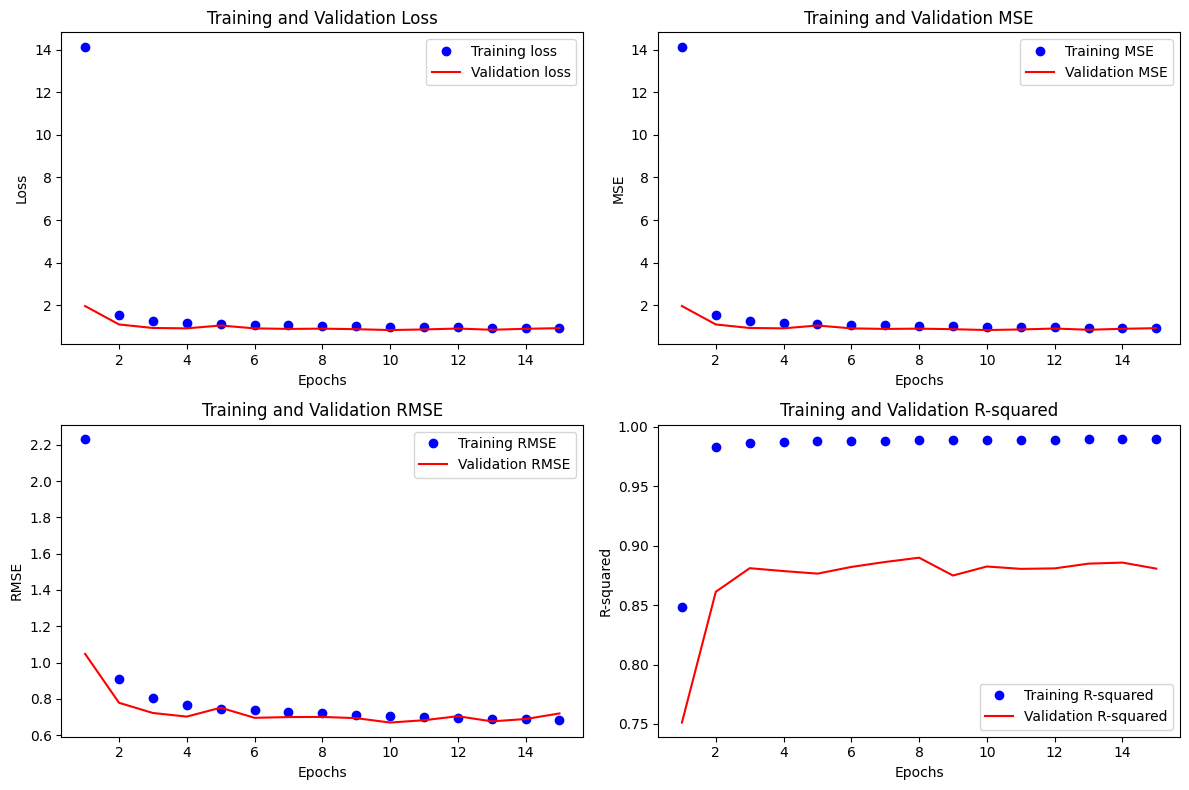

In [60]:
# Extract metrics from history
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']
rmse = history.history['rmse']
val_rmse = history.history['val_rmse']
r_squared = history.history['r_squared']
val_r_squared = history.history['val_r_squared']

# Plot training and validation loss
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12, 8))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', c='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MSE
plt.subplot(2, 2, 2)
plt.plot(epochs, mse, 'bo', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE', c='red')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Plot RMSE
plt.subplot(2, 2, 3)
plt.plot(epochs, rmse, 'bo', label='Training RMSE')
plt.plot(epochs, val_rmse, 'b', label='Validation RMSE', c='red')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot R-squared
plt.subplot(2, 2, 4)
plt.plot(epochs, r_squared, 'bo', label='Training R-squared')
plt.plot(epochs, val_r_squared, 'b', label='Validation R-squared', c='red')
plt.title('Training and Validation R-squared')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.legend()

plt.tight_layout()
plt.show()